In [ ]:
# Modelling and Evaluation

## Objectives

- Fulfill Business Requirement 2:
  - Develop a model to classify a cherry leaf as healthy or affected by powdery mildew.

## Inputs

- Image shape embeddings file (pickle format)
- Directory structure:
  ```bash
  ├── inputs 
  │       └── cherry-leaves
  │           ├── test
  │           │   ├── healthy
  │           │   └── powdery_mildew
  │           ├── train
  │           │   ├── healthy
  │           │   └── powdery_mildew
  │           └── validation
  │               ├── healthy
  │               └── powdery_mildew
  ```

## Outputs

- Data distribution visualizations for training, validation, and testing:
  - Bar chart for label distribution
  - Pie chart for dataset split
- Image augmentation samples per dataset split.
- Class indices for labeling predictions.
- Model summary and training configurations.
- Model training results and saved model file.
- Learning curves for model performance:
  - Model A - separate plots for accuracy and loss
  - Model B - complete training history visualization
  - Model C - comprehensive training history using Plotly
- Model evaluation metrics:
  - Accuracy score
  - ROC curve
  - Classification report for each model variation
- Confusion Matrix display.
- Save evaluation as a pickle file.
- Prediction testing on a random image.

## Comments | Insights | Conclusions

- Multiple visualizations are provided to support in-depth data analysis.
- The CNN model architecture aims to achieve high accuracy with minimal overfitting.
- Documentation on hyperparameter tuning is available in README.md and a detailed PDF report.

## Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from matplotlib.image import imread

---

## Set Working Directory

In [2]:
cwd = os.getcwd()

In [3]:
os.chdir('/workspaces/CI_PP5')
print("Working directory set to /workspaces/CI_PP5")

Working directory set to /workspaces/CI_PP5


In [4]:
work_dir = os.getcwd()
work_dir

'/workspaces/CI_PP5'

## Set Input Directories

Define paths for train, validation, and test directories.

In [5]:
my_data_dir = 'inputs/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set Output Directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Older version exists; consider creating a new version.')
else:
    os.makedirs(name=file_path)
    print(f"Output directory created: {file_path}")

Older version exists; consider creating a new version.


## Define Image Labels

In [7]:
labels = os.listdir(train_path)
print('Image labels are:', labels)

Image labels are: ['healthy', 'powdery_mildew']


## Load Image Shape

In [8]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

## Analyze Image Distribution

### Install and update nbformat, kaleido to Display the Plotly Figure.

In [9]:
!pip install nbformat --upgrade
!pip install kaleido

### Count Images in Each Set and Label Category

In [10]:
import plotly.express as px

df_freq = pd.DataFrame([])
for folder in ['train', 'test', 'validation']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Count': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images




### Bar Chart for Label Distribution

In [11]:
fig = px.bar(df_freq, 
            x="Set", 
            y="Count", 
            color='Label', 
            title="Distribution of Cherry Leaves Dataset")
fig.update_layout(
    autosize=False,
    width=800, 
    height=500, 
    )
fig.show()
fig.write_image(f'{file_path}/image_distribution_bar.png')

### Pie Chart for Set Distribution

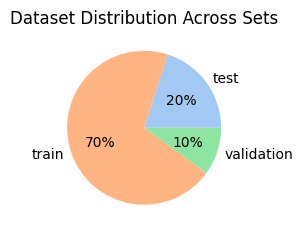

In [12]:
folders = os.listdir(my_data_dir)
data=[]
for folder in folders:
    total = 0
    for label in labels:
        n = int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))
        total += n
    data.append(total)

px = 1/plt.rcParams['figure.dpi'] 
plt.subplots(figsize=(800*px, 250*px))
colors = sns.color_palette('pastel')[0:5]
plt.pie(data, labels=folders, colors=colors, autopct='%.0f%%')
plt.title('Dataset Distribution Across Sets')
plt.savefig(f'{file_path}/set_distribution_pie.png', bbox_inches='tight', dpi=150)
plt.show()

---

## Image Data Augmentation

### Import ImageDataGenerator

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Initialize Image Augmentation Parameters

In [14]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

### Define Batch Size

In [15]:
batch_size = 8

### Augment Training Image Set

In [16]:
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Display Augmented Training Images

(8, 256, 256, 3)


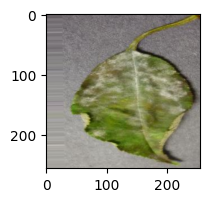

(8, 256, 256, 3)


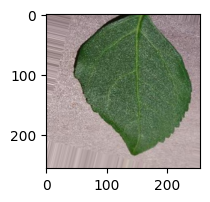

(8, 256, 256, 3)


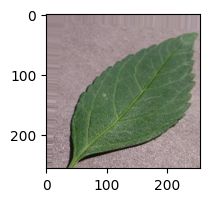

In [17]:
%matplotlib inline
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = train_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Augment Validation Image Set

In [18]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Display Augmented Validation Images

(8, 256, 256, 3)


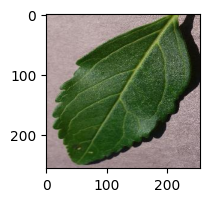

(8, 256, 256, 3)


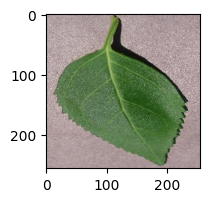

(8, 256, 256, 3)


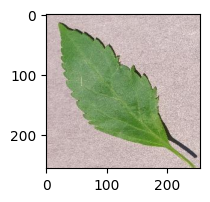

In [19]:
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = validation_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Augment Test Image Set

In [20]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=False
                                                                  )

test_set.class_indices


Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Display Augmented Test Images

(8, 256, 256, 3)


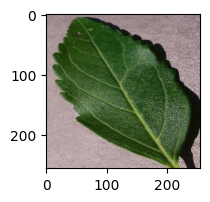

(8, 256, 256, 3)


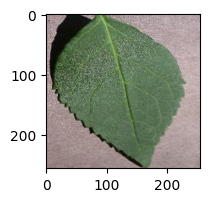

(8, 256, 256, 3)


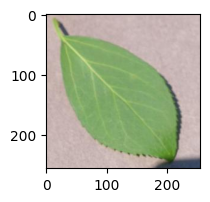

In [21]:
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = test_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Save Class Indices

In [22]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

## Model Creation

### Import Packages

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad

### Define the Model

- This model will help determine if a leaf contains powdery mildew. The rationale behind model choices is detailed in the README file.
- The model addresses Business Requirement #2.

In [24]:
def create_tf_model():
    model = Sequential()

    # Input layer
    model.add(Conv2D(32, (3, 3), input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten and fully connected layers
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(.2))

    # Output layer
    model.add(Dense(2, activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])

    return model

### Model Summary

In [25]:
create_tf_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

2024-11-06 13:12:42.942237: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Callbacks for Training

In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=2)
m_checkpoint = ModelCheckpoint(filepath='outputs/v1/powdery_mildew_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

### Train the Model

In [27]:
model = create_tf_model()
model.fit(train_set,
          batch_size=batch_size,
          epochs=32,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop, m_checkpoint],
          verbose=1
          )

2024-11-06 13:12:52.312850: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/32


2024-11-06 13:12:52.821955: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 66064384 exceeds 10% of free system memory.
2024-11-06 13:12:53.147462: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 29030400 exceeds 10% of free system memory.
2024-11-06 13:12:53.209795: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 36000000 exceeds 10% of free system memory.
2024-11-06 13:12:53.305268: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 33032192 exceeds 10% of free system memory.
2024-11-06 13:12:53.305634: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 66064384 exceeds 10% of free system memory.


368/368 [==============================] - 207s 561ms/step - loss: 0.4616 - accuracy: 0.7762 - val_loss: 0.2661 - val_accuracy: 0.9167
Epoch 2/32
368/368 [==============================] - 204s 554ms/step - loss: 0.2717 - accuracy: 0.8865 - val_loss: 0.2841 - val_accuracy: 0.8667
Epoch 3/32
368/368 [==============================] - 205s 558ms/step - loss: 0.2015 - accuracy: 0.9226 - val_loss: 0.1683 - val_accuracy: 0.9357
Epoch 4/32
368/368 [==============================] - 207s 561ms/step - loss: 0.1451 - accuracy: 0.9569 - val_loss: 0.0989 - val_accuracy: 0.9714
Epoch 5/32
368/368 [==============================] - 205s 556ms/step - loss: 0.1091 - accuracy: 0.9684 - val_loss: 0.0887 - val_accuracy: 0.9714
Epoch 6/32
368/368 [==============================] - 205s 557ms/step - loss: 0.0920 - accuracy: 0.9793 - val_loss: 0.0489 - val_accuracy: 0.9881
Epoch 7/32
368/368 [==============================] - 206s 559ms/step - loss: 0.0791 - accuracy: 0.9796 - val_loss: 0.0572 - val_accura

### Save the trained model in HDF5 format

In [28]:
model.save('outputs/v1/powdery_mildew_model.h5', save_format='h5')

### Load the Best Saved Model

In [29]:
from keras.models import load_model

best_model = load_model('outputs/v1/powdery_mildew_model.h5')

## Model Performance Visualization

### Model Learning Curve - A (Loss and Accuracy)

<Figure size 500x400 with 0 Axes>

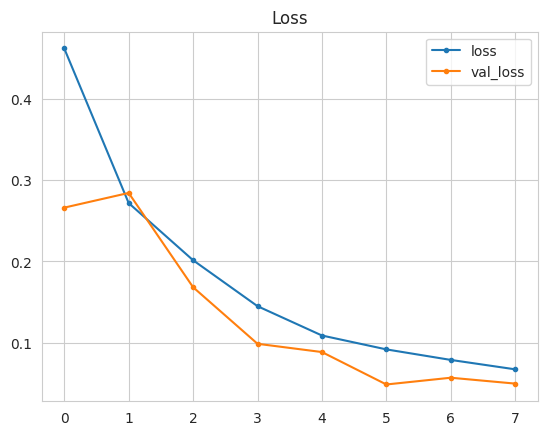

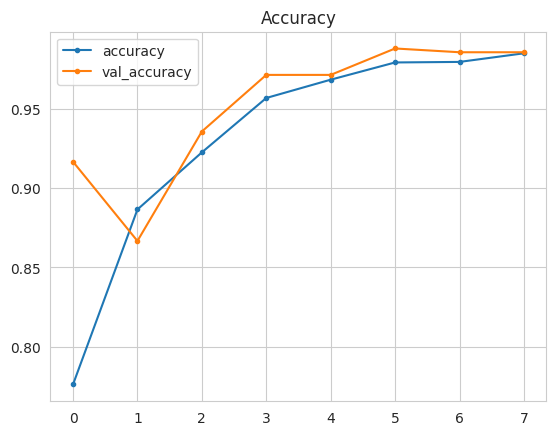

In [30]:
losses = pd.DataFrame(model.history.history)
plt.figure(figsize=(5, 4))
sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)

losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

### Model Learning Curve - B (Comprehensive View)

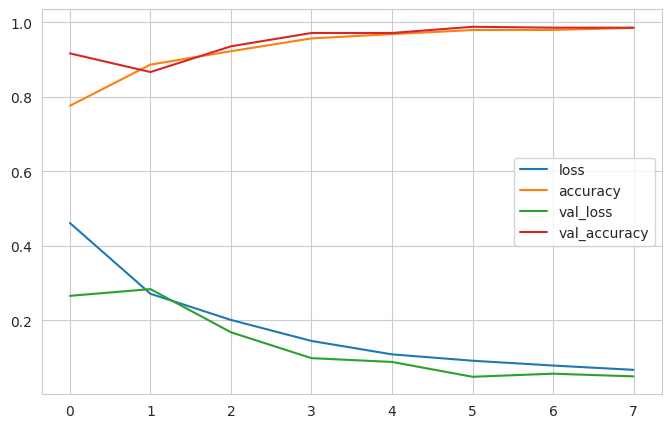

In [31]:
pd.DataFrame(model.history.history).plot(figsize=(8,5))
plt.savefig(f'{file_path}/model_loss_acc.png', bbox_inches='tight', dpi=150)
plt.show()

### Model Learning Curve - C (Detailed with Plotly)

In [32]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(y=model.history.history['val_loss'], name="val_loss"), secondary_y=False)
fig.add_trace(go.Scatter(y=model.history.history['loss'], name="loss"), secondary_y=False)
fig.add_trace(go.Scatter(y=model.history.history['val_accuracy'], name="val_accuracy"), secondary_y=True)
fig.add_trace(go.Scatter(y=model.history.history['accuracy'], name="accuracy"), secondary_y=True)

fig.update_layout(title_text="Loss/Accuracy of Model", autosize=False, width=800, height=500)
fig.update_xaxes(title_text="Epoch")
fig.update_yaxes(title_text="<b>Primary</b> Loss", secondary_y=False)
fig.update_yaxes(title_text="<b>Secondary</b> Accuracy", secondary_y=True)

fig.show()
fig.write_image(f'{file_path}/model_history.png')

## Model Evaluation

### Import Necessary Packages

In [33]:
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

### Load the Saved Model

In [34]:
from keras.models import load_model
model.save('outputs/v1/powdery_mildew_model.h5', save_format='h5')


### Model Accuracy

Evaluate model accuracy on the test set to confirm it meets project criteria (minimum 87% accuracy for Business Requirement #2).

In [35]:
evaluation = model.evaluate(test_set, batch_size=batch_size)
print("Model accuracy: {:.2f}%".format(evaluation[1] * 100))
print("Model Loss: ",evaluation[0])

106/106 [==============================] - 15s 138ms/step - loss: 0.0650 - accuracy: 0.9858
Model accuracy: 98.58%
Model Loss:  0.06498870253562927


### Set Accuracy Variables

In [36]:
validation_set.reset()

x_true, y_true = next(test_set)
preds = np.argmax(model.predict(test_set), axis=1)
y_pred = np.rint(preds)
y_true = test_set.labels

### ROC Curve

Area Under ROC-Curve:  0.985781990521327


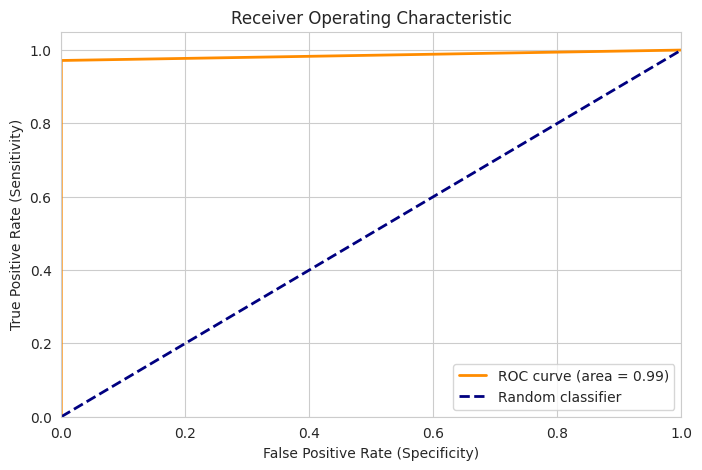

In [37]:
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score

sns.set_style("whitegrid")
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 5))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, label="Random classifier", linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig(f'{file_path}/roccurve.png', bbox_inches='tight', dpi=150)
print('Area Under ROC-Curve: ', roc_auc_score(y_true, y_pred))
plt.show()

### Confusion Matrix

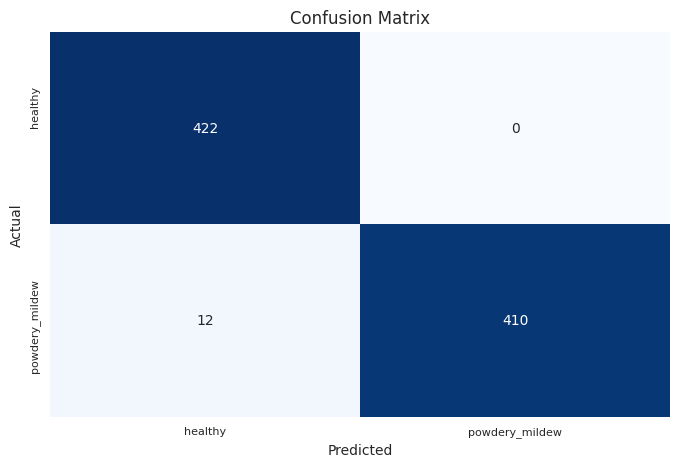

In [38]:
cm = confusion_matrix(y_true,y_pred)

classes=list(test_set.class_indices.keys())
length=len(classes)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(length)+.5, classes, rotation=0, fontsize=8)
plt.yticks(np.arange(length)+.3, classes, rotation=90, fontsize=8)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig(f'{file_path}/confusion_matrix.png', bbox_inches='tight', dpi=150)
plt.show()

### Classification Report - Text

In [39]:
print('Classification Report:\n----------------------\n')
print(classification_report(y_true, y_pred, target_names=labels))

Classification Report:
----------------------

                precision    recall  f1-score   support

       healthy       0.97      1.00      0.99       422
powdery_mildew       1.00      0.97      0.99       422

      accuracy                           0.99       844
     macro avg       0.99      0.99      0.99       844
  weighted avg       0.99      0.99      0.99       844



### Classification Report - Heatmap

Text(0.5, 1.0, 'Classification Report')

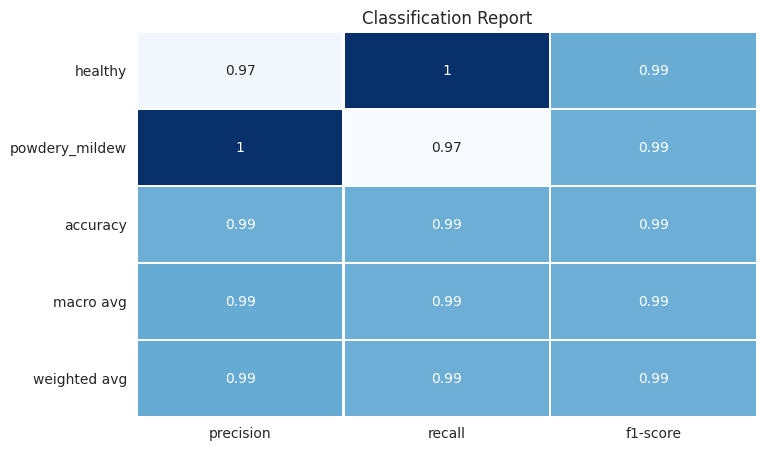

In [40]:
clf_report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap="Blues", cbar=False, linewidths=1)
plt.title('Classification Report')


### Classification Report - Enhanced

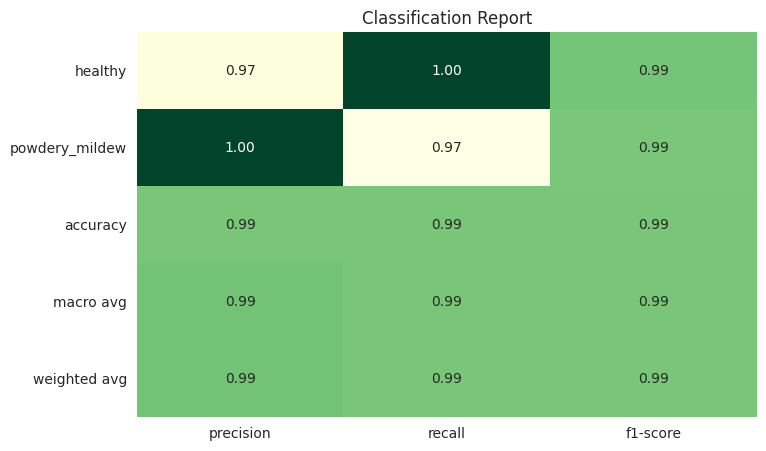

In [41]:
import pathlib
def plot_classification_report(y_true, y_pred, title='Classification Report', save_fig_path=None):
    fig, ax = plt.subplots(figsize=(8,5))
    clf_report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
    sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap="YlGn", fmt='.2f', cbar=False)
    plt.title(title)
    if save_fig_path:
        pathlib.Path(save_fig_path).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_fig_path)
    return fig, ax

fig, ax = plot_classification_report(y_true, y_pred, save_fig_path=f'{file_path}/classification_report.png')

### Save Evaluation Results

In [42]:
joblib.dump(value=evaluation, filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

---

## Predict on New Data

### Load a Random Image for Prediction

Loaded Image - Shape: (256, 256), Mode: RGB


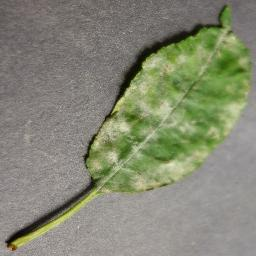

In [43]:
from tensorflow.keras.preprocessing import image

pointer = 32  # Index of the image to load for prediction
label = labels[1]  # Choose label (0 for 'healthy' or 1 for 'powdery_mildew')

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path + '/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Loaded Image - Shape: {pil_image.size}, Mode: {pil_image.mode}')
pil_image

### Convert Image to Array and Reshape for Prediction

In [44]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0) / 255  # Scale image
print(f'Reshaped Image for Prediction: {my_image.shape}')

Reshaped Image for Prediction: (1, 256, 256, 3)


### Predict Class Probabilities

In [45]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba < 0.5]  # 0.5 threshold to differentiate classes

if pred_class == target_map[1]:
    pred_proba = 1 - pred_proba

print(f"Prediction: {pred_class} with {round(pred_proba * 100, 2)}% confidence")

Prediction: powdery_mildew with 99.61% confidence
